We are analysing the L5 date from LINCS data from
https://github.com/broadinstitute/lincs-cell-painting/tree/master/consensus/2016_04_01_a549_48hr_batch1

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from cytominer_eval import evaluate
from pycytominer.cyto_utils import infer_cp_features

In [59]:
data_dir = 'data/2016_04_01_a549_48hr_batch1_consensus_modz_feature_select_dmso.csv.gz'
df = pd.read_csv(data_dir)
print(df.shape)
features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)
len(df.Metadata_broad_sample.unique())

(10752, 528)


1571

The data has large deviations!
We need to delete all features that have very large values.
Some example below:
BRD-A26334849-001-06-2
BRD-A25234499-001-18-3

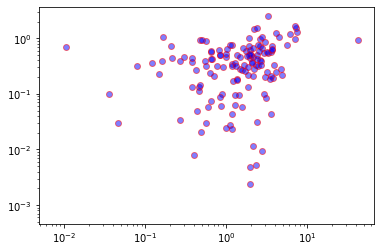

In [58]:
s1 = "BRD-A26334849-001-06-2"
s2 = "BRD-A25234499-001-18-3"
two = pd.concat([
df.query("Metadata_broad_sample==@s1  & Metadata_mmoles_per_liter == 10.0"),
df.query("Metadata_broad_sample==@s2  & Metadata_mmoles_per_liter == 10.0")
    ], ignore_index=True)
two = two.loc[:, features]
two = two.T
two.columns = ['One','Two']

fig = plt.figure()
ax = plt.gca()
ax.plot(two['One'] ,two['Two'], 'o', c='blue', alpha=0.5, markeredgecolor='red')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [56]:
# looking for the bad apples.
print("Total number of features:", len(features))
count = 0
for feature in features:
    if (np.abs(df[feature]) > 100).any():
        count += 1
print("want to drop", count, "features")

Total number of features: 493
want to drop 6 features


In [66]:
def drop_bad_feats(df_old, features_old, threshold):
    drop_features = []
    for feat in features_old:
        if (np.abs(df_old[feat]) > threshold).any():
            drop_features.append(feat)
    df_clean = df.drop(drop_features,  axis = "columns")
    print("dropped {} features".format(len(drop_features)))
    return df_clean
df_clean = drop_bad_feats(df, features, 100)

dropped 32 features


First compute Precision and Enrichment with old features


In [67]:
data_dir = 'data/2016_04_01_a549_48hr_batch1_consensus_modz_feature_select_dmso.csv.gz'
df = pd.read_csv(data_dir)
print(df.shape)
features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)
len(df.Metadata_broad_sample.unique())

ls = df.Metadata_moa.unique()[:20].tolist()
selected_moa= df.query("Metadata_moa==@ls")
len(selected_moa)

precision_recall_at_k = []
for k in [2, 5, 10, 20]:
    precision_recall_results = evaluate(
        profiles=selected_moa,
        features=features,
        meta_features=meta_features,
        replicate_groups=["Metadata_broad_sample"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k=k
    )
    precision_recall_at_k.append(precision_recall_results)
df_res = pd.concat(precision_recall_at_k).reset_index(drop=True)
pr_av = []
for k in df_res.k.unique():
    pr_av.append(df_res.query("k==@k").mean().tolist())
pd.DataFrame(pr_av, columns=["k","precision","recal"])

(10752, 528)


,k,precision,recal
0,2.0,0.034759,0.002317
1,5.0,0.025668,0.004278
2,10.0,0.026203,0.008021
3,20.0,0.027540,0.017112


In [ ]:
replicate_groups=['Metadata_moa']
result = []

for p in np.arange(0.995, 0.97, -0.005):
    r = evaluate(
        profiles=selected_moa,
        features=features,
        meta_features=meta_features,
        replicate_groups=replicate_groups,
        operation="enrichment",
        similarity_metric="pearson",
        percentile=p,
    )
    result.append(r)
result_df = pd.DataFrame(result)
result_df[["percentile","ods_ratio"]]

Now compare the effect of improvement

In [69]:
data_dir = 'data/2016_04_01_a549_48hr_batch1_consensus_modz_feature_select_dmso.csv.gz'
df = pd.read_csv(data_dir)
df_clean = drop_bad_feats(df, features, 100)
features = infer_cp_features(df_clean)
meta_features = infer_cp_features(df_clean, metadata=True)
ls = df_clean.Metadata_moa.unique()[:20].tolist()
selected_moa= df_clean.query("Metadata_moa==@ls")
print(len(selected_moa))

precision_recall_at_k = []
for k in [2, 5, 10, 20]:
    precision_recall_results = evaluate(
        profiles=selected_moa,
        features=features,
        meta_features=meta_features,
        replicate_groups=["Metadata_broad_sample"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k=k
    )
    precision_recall_at_k.append(precision_recall_results)
df_res = pd.concat(precision_recall_at_k).reset_index(drop=True)
pr_av = []
for k in df_res.k.unique():
    pr_av.append(df_res.query("k==@k").mean().tolist())
pd.DataFrame(pr_av, columns=["k","precision","recal"])

dropped 32 features
1788


,k,precision,recal
0,2.0,0.655080,0.043316
1,5.0,0.601070,0.099465
2,10.0,0.511230,0.168984
3,20.0,0.415775,0.274688
